In [1]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=fb5bc2171c7ff77cafa5ba8a7a6b72e8228618f6bd672ac834ad6fa8ad597038
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [2]:
!pip install backtesting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173913 sha256=250be3158793b19242138df4dc7f066c7abcc9e3b81e2f35951bb3916767066f
  Stored in directory: /root/.cache/pip/wheels/e2/30/7f/19cbe31987c6ebdb47f1f510343249066711609e3da2d57176
Successfully built backtesting


In [3]:
import pandas as pd
import pandas_ta as ta
import requests
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import backtesting as bt

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


In [38]:
key = 'GTVYSR9SUZQ0NJMI'
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=ACGL&outputsize=full&apikey={key}&datatype=csv'


In [39]:
df = pd.read_csv(url)
df = pd.DataFrame(df)
display(df.head())

,timestamp,open,high,low,close,volume
0,2024-08-26,108.99,110.120,108.840,109.49,1228005
1,2024-08-23,106.96,109.145,106.335,109.02,1514536
2,2024-08-22,104.75,106.540,104.750,106.51,1144956
3,2024-08-21,103.20,104.720,102.970,104.60,1013401
4,2024-08-20,102.97,103.290,102.275,102.80,700724


In [57]:
df_dup = df.copy()
df_dup['timestamp'] = pd.to_datetime(df_dup['timestamp'])
df_dup.set_index('timestamp', inplace = True)
df_dup.tail()


,open,high,low,close,volume
timestamp,,,,,
1999-11-05,13.25,13.94,13.25,13.88,41600
1999-11-04,13.25,13.58,13.25,13.25,6400
1999-11-03,13.56,13.69,13.25,13.25,2900
1999-11-02,13.28,13.63,13.12,13.44,13900
1999-11-01,13.37,13.69,13.06,13.06,15300


In [58]:
df_dup = df_dup[((df_dup.index >= pd.to_datetime('2012-01-01')) & (df_dup.index <= pd.to_datetime('2018-01-01')))]

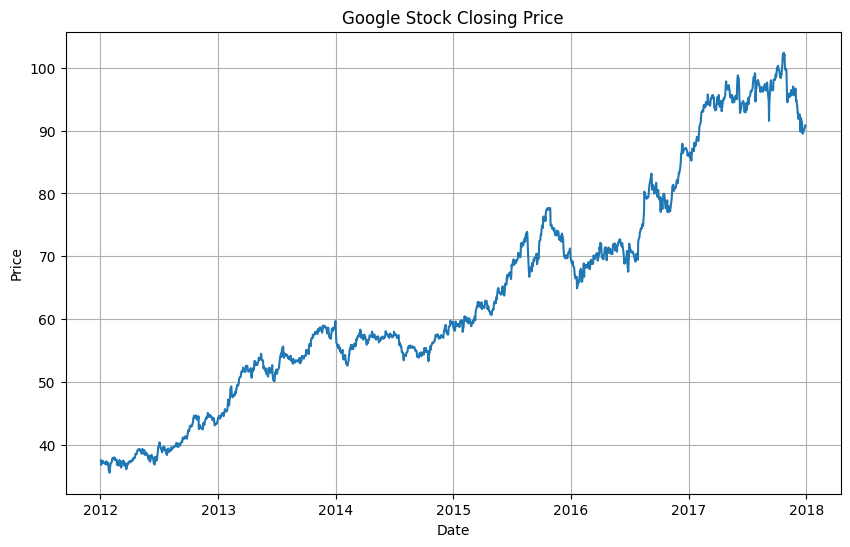

In [59]:
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(df_dup['close'])
plt.title('Google Stock Closing Price')
plt.show()

In [60]:
#First we need to check if this time series data is stationary , since time series works well with stationary data
#Use Augmented Dickey Fuller test , if p<0.05 then reject H0 and say that data is stationary

In [61]:
#Checking for Stationarity
from statsmodels.tsa.stattools import adfuller

def CheckStationarity(df):
  stats = adfuller(df)
  #print(result)
  #print('ADF Statistic: %f' % result[0])
  #print('p-value: %f' % result[1])
  output = pd.Series(stats[0:4], index = ['Test Statistic' , 'p-value' , '#Lags Used' , 'Number of Observations Used'])
  print(output)


CheckStationarity(df_dup['close'])


Test Statistic                   -0.640058
p-value                           0.861671
#Lags Used                        0.000000
Number of Observations Used    1508.000000
dtype: float64


In [63]:
#We try to decompose the data into different components of time series - trend, seasonal, and residual
from statsmodels.tsa.seasonal import seasonal_decompose



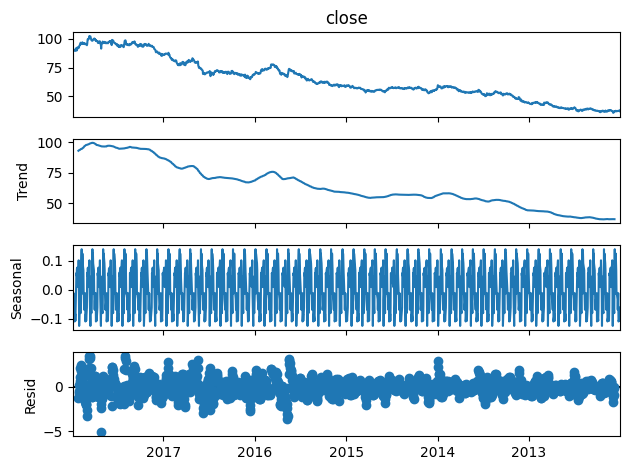

<Figure size 1400x800 with 0 Axes>

In [64]:
result = seasonal_decompose(df_dup['close'], model = 'additive', period = 30)
result.plot()
plt.figure(figsize = (14, 8))
plt.show()

In [65]:
#Since p-val > 0.05 , we DO NOT reject Ho and conclude that our data is NOT stationary
#So to make it stationary we take the log of the close and try to reduce the skewness
#df.close/df.close.shift(1) : basically shift(1) moves the data by 1 period down, and now df.close/df.close.shift is basically the return of new period compared to older period. We then take log of this value.

# df_dup['log close'] = np.log(df_dup['close']/df_dup['close'].shift(1))
#df_dup['log close'] = np.log(df_dup['close'])
df_dup = np.log(df_dup/df_dup.shift(1))

df_dup.dropna(inplace = True)
df_dup.head()

,open,high,low,close,volume
timestamp,,,,,
2017-12-28,-0.004737,-0.002909,-0.009418,0.000881,-0.338125
2017-12-27,-0.003318,-0.000770,0.000445,-0.004081,0.285890
2017-12-26,-0.008121,0.000880,-0.003790,-0.002324,-0.363257
2017-12-22,-0.000335,-0.008278,-0.001490,-0.006223,0.118759
2017-12-21,0.000893,-0.002997,-0.001042,-0.002344,0.323391


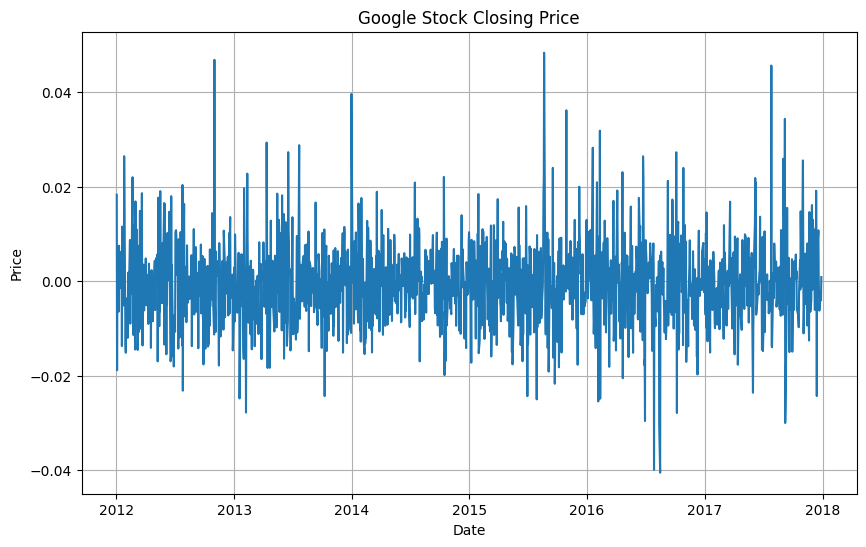

In [66]:
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(df_dup['close'])
plt.title('Google Stock Closing Price')
plt.show()

In [71]:
#Now check this transformed data with the Augmented Dickey Fuller test
CheckStationarity(df_dup['close'])

Test Statistic                  -29.237941
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1506.000000
dtype: float64


In [72]:
df_log = df_dup.copy()
df_log.drop(['open', 'high', 'low', 'volume'], axis = 1, inplace = True)
df_log.head()
# df_log.rev

,close
timestamp,
2017-12-28,0.000881
2017-12-27,-0.004081
2017-12-26,-0.002324
2017-12-22,-0.006223
2017-12-21,-0.002344


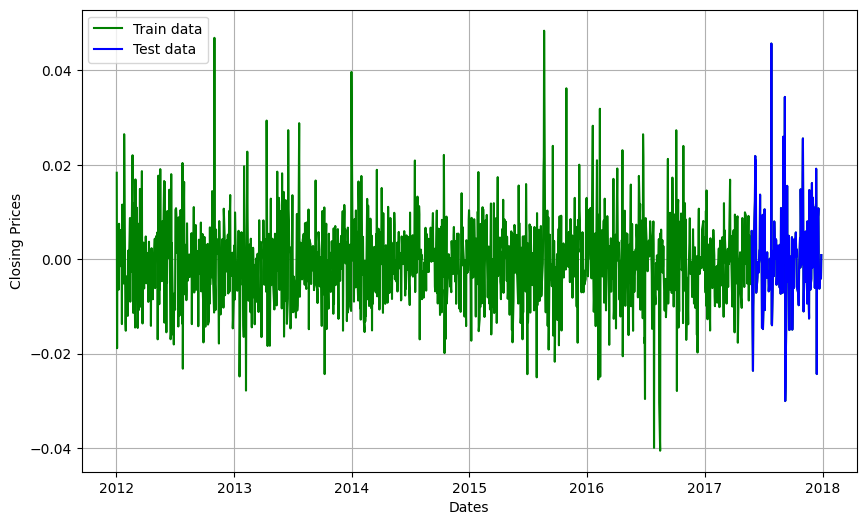

In [73]:
#Now the p-val <0.05 , so the data is statioanry
#split data to train and test

train_data, test_data = df_log[int(len(df_log)*0.1):], df_log[:int(len(df_log)*0.1)]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [74]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.4 MB/s eta 0:00:00


In [75]:
#We now use Auto Arima to find the best fit paraemeters of p,d,q
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-8980.767, Time=1.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-8981.371, Time=0.58 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-8981.567, Time=1.81 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-8980.086, Time=1.41 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-8981.195, Time=2.78 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-8979.622, Time=1.92 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-8988.748, Time=2.39 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-8987.009, Time=0.72 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-8987.969, Time=2.31 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-8989.101, Time=7.13 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-8987.369, Time=2.23 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-8987.638, Time=3.90 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-8985.645, Time=1.56 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0] intercept
Total fit time: 29.922 seconds
        

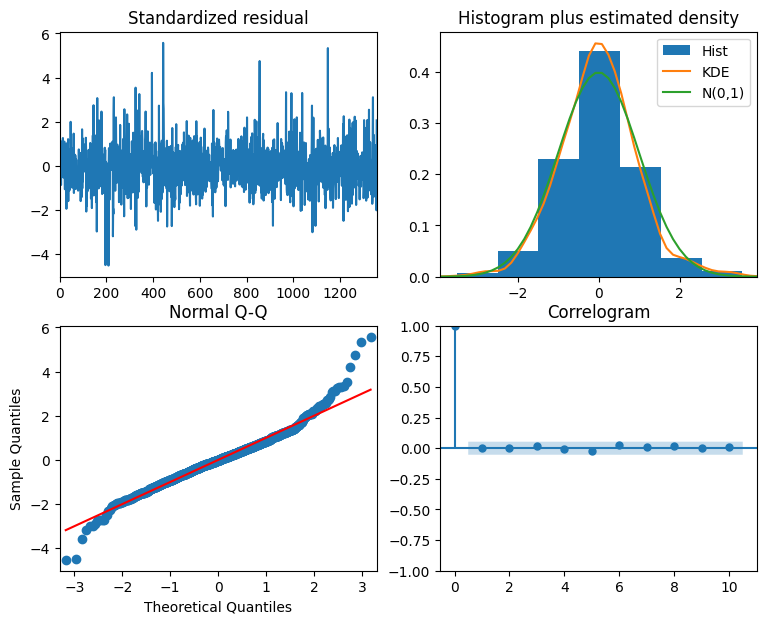

In [76]:
model_auto = auto_arima(train_data, start_p=0, start_q=0,
                        test='adf',       # use adftest to find optimal 'd'
                        max_p=3, max_q=3, # maximum p and q
                        m=1,              # frequency of series
                        d=None,           # let model determine 'd'
                        seasonal=False,   # No Seasonality
                        start_P=0,
                        D=0,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)
print(model_auto.summary())
model_auto.plot_diagnostics(figsize=(9,7))
plt.show()